# Data Preproccessing
## Create image patches from data

In [1]:
from PatchifyMBRSC import patchify

patch_size=496
patchify(patch_size, stride=patch_size, rotate=True)

## Calculate mean and standard deviation of each channel

In [2]:
#from PatchifyMBRSC import get_channel_normalization_params
#means, stds = get_channel_normalization_params()
#print(means, stds)
#means = [0.525091009935856, 0.5349247905585822, 0.5491133125103805]
#stds = [0.2972007767501209, 0.30354216287443164, 0.3211262417037121]

# Visualize dataset

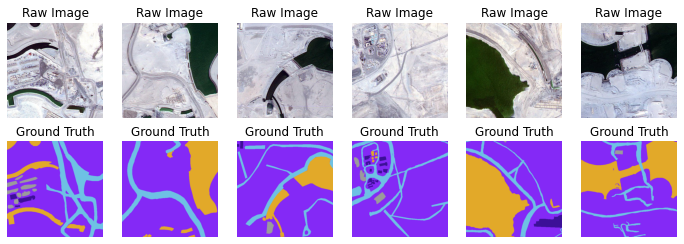

In [3]:
import matplotlib.pyplot as plt
import numpy as np
from MBRSC import MBRSC
from PIL import Image

idxs = [1, 5, 9, 13, 18, 23]
fig, axes = plt.subplots(nrows=2, ncols=len(idxs), figsize=(12, 4))
for i, idx in enumerate(idxs):
    pic = np.array(Image.open("MBRSC/Patched/image{}.jpg".format(idx)))
    label = np.array(Image.open("MBRSC/Patched/mask{}.png".format(idx)))
    label = MBRSC.add_label_colors(label)
    
    axes[0][i].axis('off')
    axes[0][i].imshow(pic)
    axes[0][i].set_title("Raw Image")

    axes[1][i].imshow(label)
    axes[1][i].axis('off')
    axes[1][i].set_title("Ground Truth")

# Load in training data and create data loaders

In [4]:
import torch
from torch.utils.data import Dataset
import os
import os.path as osp
from MBRSC import MBRSC

def get_full_list(root_dir):
    data_list = []
    data_list += sorted(
        osp.join(root_dir, img_name) for img_name in
        filter(
            lambda x: x[-4:] == '.jpg',
            os.listdir(root_dir)
        )
    )
    
    return np.array(data_list)

full_data_list = get_full_list('MBRSC/Patched')
np.random.shuffle(full_data_list)

num_images = full_data_list.shape[0]
TRAIN_SIZE = int(0.7*num_images)
VAL_SIZE = int(0.1*num_images)
TEST_SIZE = num_images-TRAIN_SIZE-VAL_SIZE

train_data_set = MBRSC(full_data_list[: TRAIN_SIZE])
val_data_set = MBRSC(full_data_list[TRAIN_SIZE: TRAIN_SIZE + VAL_SIZE])
test_data_set = MBRSC(full_data_list[TRAIN_SIZE + VAL_SIZE:])

print("Training Set Size:", len(train_data_set))
print("Validation Set Size:", len(val_data_set))
print("Test Set Size:", len(test_data_set))

Training Set Size: 554
Validation Set Size: 79
Test Set Size: 159


In [5]:
train_loader = torch.utils.data.DataLoader(
    train_data_set, batch_size=1, shuffle=True
)
val_loader = torch.utils.data.DataLoader(
    val_data_set, batch_size=1, shuffle=True
)
test_loader = torch.utils.data.DataLoader(
    test_data_set, batch_size=1, shuffle=False
)


USE_GPU = True

dtype = torch.float32

if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

# Constant to control how frequently we print train loss
print_every = 100

print('using device:', device)

using device: cuda


# Define metrics and training functions

In [6]:
import numpy as np

def _hist(pred, gt, n_class):
    hist = n_class * gt.astype(int) + pred
    hist = np.bincount(hist, minlength=n_class ** 2)
    hist = hist.reshape(n_class, n_class)
    return hist

def metrics(preds, gts, n_class):
    hist = np.zeros((n_class, n_class))
    for pred, gt in zip(preds, gts):
        hist += _hist(pred.flatten(), gt.flatten(), n_class)
    acc = np.diag(hist).sum() / hist.sum()
    iou = np.diag(hist) / (
        hist.sum(axis=1) + hist.sum(axis=0) - np.diag(hist)
    )
    mean_iou = np.nanmean(iou)
    return acc, mean_iou

In [7]:
import copy
import torch.nn as nn

def Evaluate(
    val_loader,
    model,
    current_best,
    n_class=6
):
    val_loss = 0
    visualizations = []
    preds, gts = [], []
    
    model.eval()
    for batch_idx, (data, target) in enumerate(val_loader):
        data, target = data.to(device), target.to(device)
        with torch.no_grad():
            score = model(data)
        pred = score.max(1)[1].cpu().numpy()
        
        
        gt = target.cpu().numpy()
        preds.append(pred)
        gts.append(gt)

    avg_acc, mean_iou = metrics(
        preds, gts, n_class)

    if mean_iou > current_best["IoU"]:
        current_best["IoU"] = mean_iou
        current_best["model"] = copy.deepcopy(model)

    return avg_acc, mean_iou, current_best

def Train(
    model,
    loss_func,
    optim,
    epochs,
    train_loader,
    val_loader,
    test_loader,
    display_interval = 100,
    scheduler=None
):

    current_best = {
        "IoU": 0,
        "model": model
    }
    avg_acc, mean_iou, current_best = Evaluate(
        val_loader,
        model,
        current_best
    )
    
    print("Init Model")
    print("Avg Acc: {:.4}, Mean IoU: {:.4}".format(
        avg_acc, mean_iou
    ))
    for i in range(epochs):
        print("Epochs: {}".format(i))
        total_loss = 0
        model.train()
        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to("cuda:0"), target.to("cuda:0")
            optim.zero_grad()

            score = model(data)
            
            loss = loss_func(score, target.squeeze(1))
            loss_data = loss.item()
            if np.isnan(loss_data):
                raise ValueError('loss is nan while training')
            loss.backward()
            optim.step()
            total_loss += loss.item()
            
        total_loss /= len(train_loader)
        model.eval()
        avg_acc, mean_iou, current_best = Evaluate(val_loader, model, current_best)
        if scheduler is not None:
            scheduler.step(total_loss)
        print("Avg Loss: {:.4}, Avg Acc: {:.4}, Mean IoU: {:.4}".format(
            total_loss, avg_acc, mean_iou
        ))
    
    test_acc, test_iou, current_best = Evaluate(val_loader, current_best["model"], current_best)
    print("Test Acc: {:.4}, Test Mean IoU: {:.4}".format(
        test_acc, test_iou
    ))
    return current_best["model"]


from torch.optim.lr_scheduler import ReduceLROnPlateau

def Trainer(model, 
            train_loader,
            val_loader,
            test_loader,
            num_epochs=25, 
            ):
    # define optimizer
    lr = 1e-4
    weight_decay = 2e-5
    optim = torch.optim.Adam(
        model.parameters(),
        lr=lr,
        weight_decay=weight_decay,
    )
    
    # define learning rate schedule
    scheduler = ReduceLROnPlateau(
        optim, 'min', patience=3,
        min_lr=1e-10, verbose=True
    )
    
    # define loss function
    loss_func = nn.CrossEntropyLoss()

    best_model = Train(
        model,
        loss_func,
        optim,
        num_epochs,
        train_loader,
        val_loader,
        test_loader,
        scheduler=scheduler
    )

    return best_model

# Implement and train U-net

In [8]:
import torch
import torch.nn as nn

class Unet(nn.Module):
    def __init__(self, n_class=6, batch_norm=True, init_weights=True):
        super(Unet, self).__init__()
        self.pool = nn.MaxPool2d(2, stride=2)
        
        self.batch_norm = batch_norm
        size = 16
        self.conv_down1 = self.double_conv(3, size)
        self.conv_down2 = self.double_conv(size, size*2)
        self.conv_down3 = self.double_conv(size*2, size*4)
        self.conv_down4 = self.double_conv(size*4, size*8)
        self.conv_down5 = self.double_conv(size*8, size*16)

        self.conv_up1 = self.double_conv(size*16, size*8)
        self.conv_up2 = self.double_conv(size*8, size*4)
        self.conv_up3 = self.double_conv(size*4, size*2)
        self.conv_up4 = self.double_conv(size*2, size)

        self.upscore1 = nn.ConvTranspose2d(size*16, size*8, 2, stride=2)
        self.upscore2 = nn.ConvTranspose2d(size*8, size*4, 2, stride=2)
        self.upscore3 = nn.ConvTranspose2d(size*4, size*2, 2, stride=2)
        self.upscore4 = nn.ConvTranspose2d(size*2, size, 2, stride=2)
        
        self.conv1x1 = self.conv_layer(size, n_class, 1, activation=nn.Sigmoid())
        
        if init_weights:
            for m in self.modules():
                if isinstance(m, nn.Conv2d):
                    if m.kernel_size == 1:
                        nn.init.kaiming_normal_(m.weight, nonlinearity='sigmoid')
                    else:
                        nn.init.kaiming_normal_(m.weight, nonlinearity='relu')
                elif isinstance(m, nn.BatchNorm2d):
                    nn.init.constant_(m.weight, 1) 
                    nn.init.constant_(m.bias, 0)

    
    def double_conv(self, in_channel, out_channel, p=0.1):
        return nn.Sequential(
            self.conv_layer(in_channel, out_channel),
            #nn.Dropout(0.1),
            self.conv_layer(out_channel, out_channel)
        )
    def crop(self, tensor_in, tensor_out):
        size_out = tensor_out.size()[2]
        size_in = tensor_in.size()[2]
        start = (size_in-size_out)//2
        return tensor_in[:,:, start:start+size_out, start:start+size_out]

    def decode(self, up_tensor, right_tensor, upscore, conv):
        up_tensor = upscore(up_tensor)
        right_tensor = self.crop(right_tensor, up_tensor)
        return conv(torch.cat([up_tensor, right_tensor], dim=1))

    def conv_layer(self, in_channel, out_channel, size=3, activation=None):
        conv = nn.Conv2d(in_channel, out_channel, size, padding='same')
        if activation is None:
            conv = nn.Sequential(conv, nn.ReLU(inplace=True))
        else:
            conv = nn.Sequential(conv, activation)
        if self.batch_norm:
            conv = nn.Sequential(conv, nn.BatchNorm2d(out_channel))
        return conv

    def forward(self, image):

        # Encoding
        out1 = self.conv_down1(image)
        out2 = self.conv_down2(self.pool(out1))
        out3 = self.conv_down3(self.pool(out2))
        out4 = self.conv_down4(self.pool(out3))
        out5 = self.conv_down5(self.pool(out4))
        
        # Decoding
        out6 = self.decode(out5, out4, self.upscore1, self.conv_up1)
        out7 = self.decode(out6, out3, self.upscore2, self.conv_up2)
        out8 = self.decode(out7, out2, self.upscore3, self.conv_up3)
        out9 = self.decode(out8, out1, self.upscore4, self.conv_up4)
        h = self.conv1x1(out9)
        
        
        return h

model32 = Unet(n_class=6, batch_norm=True, init_weights=False)
model32.to(device)

best_model = Trainer(
    model32,
    train_loader,
    val_loader,
    test_loader,
    num_epochs=20
)

#0.4888, good training, dropout0.1, batchnorm, no init weights, patchsize 500, rotations, size 16
#0.33, good training, dropout0.1, batchnorm, init weigths, patch size 300,no rotations, size 16
#dropout0.1, batch norm, no weights, patch size 500, rotations, size 64, 0.48 ioU, overfitted
#patchsize 250, no rotations, no dropout, batch norm, init weights, size 16 0.2 iou
#patchsize 496, rotate, no dropout, batchnorm, no init weights, size 16, padding same, 0.5203 iou
#patchsize 496, rotate, dropout0.1, batchnorm, no init weights, size 16, padding same, 0.4541 iou
#patchsize 256, rotate, no dropout, batchnorm, no init weights, size 16, padding same, 0.5 iou
#patchsize 496, no rotate, no dropout, batchnorm, no init weights, size 16, padding same, 0.4 iou, fast training
#patchsize 496, rotate, no dropout, batchnorm, no init weights, size 16, padding same, 0.49 iou


/opt/conda/lib/python3.9/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Init Model
Avg Acc: 0.5637, Mean IoU: 0.09395
Epochs: 0
Avg Loss: 1.681, Avg Acc: 0.5407, Mean IoU: 0.2468
Epochs: 1
Avg Loss: 1.477, Avg Acc: 0.5635, Mean IoU: 0.2286
Epochs: 2
Avg Loss: 1.4, Avg Acc: 0.6037, Mean IoU: 0.2897
Epochs: 3
Avg Loss: 1.342, Avg Acc: 0.6859, Mean IoU: 0.3488
Epochs: 4
Avg Loss: 1.293, Avg Acc: 0.7144, Mean IoU: 0.3607
Epochs: 5
Avg Loss: 1.243, Avg Acc: 0.739, Mean IoU: 0.3935
Epochs: 6
Avg Loss: 1.197, Avg Acc: 0.7905, Mean IoU: 0.4425
Epochs: 7
Avg Loss: 1.156, Avg Acc: 0.7623, Mean IoU: 0.3873
Epochs: 8
Avg Loss: 1.114, Avg Acc: 0.8142, Mean IoU: 0.4778
Epochs: 9
Avg Loss: 1.079, Avg Acc: 0.7354, Mean IoU: 0.3467
Epochs: 10
Avg Loss: 1.044, Avg Acc: 0.7353, Mean IoU: 0.3422
Epochs: 11
Avg Loss: 1.007, Avg Acc: 0.8024, Mean IoU: 0.4459
Epochs: 12
Avg Loss: 0.9747, Avg Acc: 0.7729, Mean IoU: 0.4187
Epochs: 13
Avg Loss: 0.9411, Avg Acc: 0.8128, Mean IoU: 0.4909
Epochs: 14
Avg Loss: 0.9123, Avg Acc: 0.7764, Mean IoU: 0.4009
Epochs: 15
Avg Loss: 0.8811, Avg A

# Visualize results

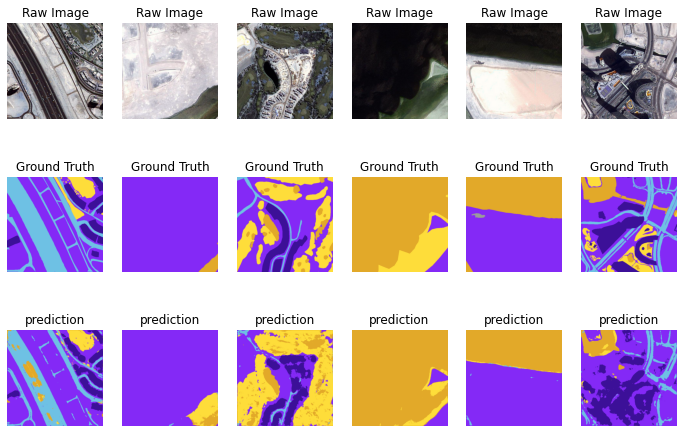

In [9]:
import matplotlib.pyplot as plt

def visualize(model, test_loader):
    idxs = np.random.randint(0, len(test_loader.dataset), 6)
    fig, axes = plt.subplots(nrows=3, ncols=6, figsize=(12, 8))
    model.eval()
    for i, idx in enumerate(idxs):
        img, label = test_loader.dataset[idx]
        
        pred = model(img.unsqueeze(0).to(device)) 
        pred = (pred.max(1)[1]).squeeze(0).cpu().numpy()
        pred = MBRSC.add_label_colors(pred)
        
        img, label = test_loader.dataset.revert_input(img, label)
        
        axes[0][i].axis('off')
        axes[0][i].imshow(img)
        axes[0][i].set_title("Raw Image")

        axes[1][i].imshow(label)
        axes[1][i].axis('off')
        axes[1][i].set_title("Ground Truth")

        axes[2][i].imshow(pred)
        axes[2][i].axis('off')
        axes[2][i].set_title("prediction")

visualize(best_model, test_loader)